/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


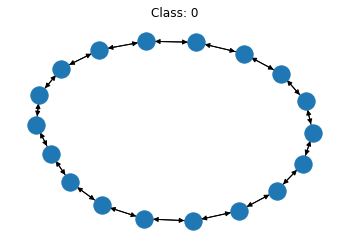

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [2]:
import dgl
import torch
def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [3]:
import dgl.function as fn
import torch
import torch.nn as nn

msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super().__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation
        
    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h': h}
    
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super().__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)
        
    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [4]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super().__init__()
        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)
        ])
        self.classify = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader

trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
data_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate)

model = Classifier(1, 512, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (layers): ModuleList(
    (0): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=512, bias=True)
      )
    )
    (1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
    )
  )
  (classify): Linear(in_features=512, out_features=8, bias=True)
)

In [6]:
epoch_losses = []
for epoch in range(150):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print("Epoch %d, loss %.4f" % (epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

/usr/local/anaconda3/envs/czh/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, loss 2.3636
Epoch 1, loss 1.9601
Epoch 2, loss 1.8686
Epoch 3, loss 1.7550
Epoch 4, loss 1.6312
Epoch 5, loss 1.5806
Epoch 6, loss 1.4773
Epoch 7, loss 1.4287
Epoch 8, loss 1.3242
Epoch 9, loss 1.2554
Epoch 10, loss 1.2093
Epoch 11, loss 1.2010
Epoch 12, loss 1.1310
Epoch 13, loss 1.0909
Epoch 14, loss 1.0351
Epoch 15, loss 1.0096
Epoch 16, loss 0.9971
Epoch 17, loss 0.9911
Epoch 18, loss 0.9837
Epoch 19, loss 0.9227
Epoch 20, loss 0.9197
Epoch 21, loss 0.9071
Epoch 22, loss 0.8958
Epoch 23, loss 0.8965
Epoch 24, loss 0.8501
Epoch 25, loss 0.8489
Epoch 26, loss 0.8055
Epoch 27, loss 0.8147
Epoch 28, loss 0.7961
Epoch 29, loss 0.8143
Epoch 30, loss 0.7740
Epoch 31, loss 0.7843
Epoch 32, loss 0.7868
Epoch 33, loss 0.7822
Epoch 34, loss 0.7910
Epoch 35, loss 0.7311
Epoch 36, loss 0.7575
Epoch 37, loss 0.7418
Epoch 38, loss 0.7767
Epoch 39, loss 0.6873
Epoch 40, loss 0.6673
Epoch 41, loss 0.6645
Epoch 42, loss 0.6768
Epoch 43, loss 0.6995
Epoch 44, loss 0.6945
Epoch 45, loss 0.640

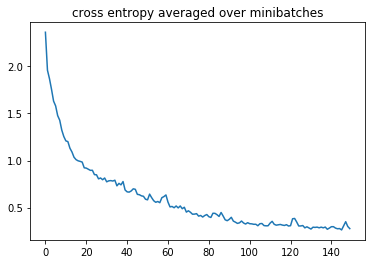

In [7]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [8]:
model.eval()
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 80.0000%
Accuracy of argmax predictions on the test set: 87.500000%
